In [1]:
import sys

# Para podermos importar o utils
sys.path.append("../")

In [2]:
%config Completer.use_jedi = False
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from scipy.optimize import root_scalar, curve_fit
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from utils import wrangle_data

# 44.04 Milhões de habitantes em SP
SP_POP = 44.04e6

In [3]:
data = pd.read_csv("../data/vacinados_clean.csv", parse_dates=["Data"])
data.head()

,Data,Vacinados,Delta
0,2021-01-19 11:16:00,3908,NaN
1,2021-01-20 14:14:00,17318,13410.0
2,2021-01-20 15:11:00,18409,1091.0
3,2021-01-20 15:19:00,18729,320.0
4,2021-01-20 15:24:00,18834,105.0


In [4]:
# Agrupa registros q aconteceram dentro da mesma hora e escolhe o maior valor
vacinados_hora = wrangle_data(data)

x, y = vacinados_hora.index, vacinados_hora

In [5]:
# Sem o -1 porque vou ignorar o primeiro dia
hora_inicial = data.Data.dt.dayofyear.min()*24
# Gerando as linhas q indicam o começo de cada dia
vlines = [hora_inicial + 24 * i for i in range(data.Data.dt.dayofyear.max()-data.Data.dt.dayofyear.min())]

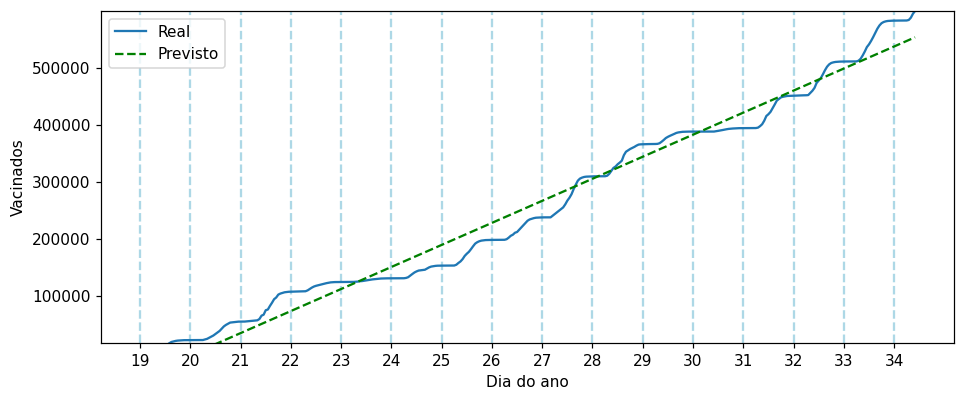

In [6]:
fig, ax = plt.subplots(figsize = (10,4), dpi=110)

# Encontrando um polinômio de grau 1 q aproxima a curva
m, b = np.polyfit(vacinados_hora.index, vacinados_hora, 1)

def modelo_linear(x, m=m, b=b):
    return m * x + b

ax.plot(x, y, label="Real")
ax.plot(x, modelo_linear(x), color='g', linestyle='--', label="Previsto")
ax.set(xlabel="Dia do ano",
       ylabel="Vacinados",
       ylim=(y.min(), y.max()), 
       xticks=vlines,
       xticklabels=np.array(vlines)//24)
ax.legend()

ax.vlines(vlines, ymin=vacinados_hora.min(), ymax=vacinados_hora.max(), color='lightblue', linestyle='--');

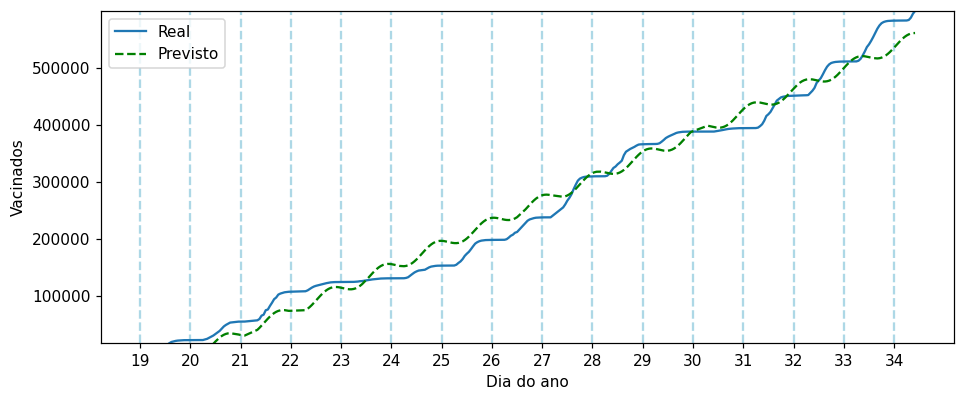

In [7]:
fig, ax = plt.subplots(figsize = (10,4), dpi=110)

# Vamos tentar incorporar o elemento periódico manualmente 
# (esse valores são encontrados usando tentativa e error)
amplitude = 10000
freq = 0.25
fase = np.pi

# Adicionamos um termos periódico (seno) à nossa reta
def modelo_periodico(x, amplitude, freq, fase, m=m, b=b):
    return modelo_linear(x, m, b) + amplitude*np.sin(freq*x + fase)

ax.plot(vacinados_hora.index, vacinados_hora, label="Real")
ax.plot(x, modelo_periodico(x, amplitude, freq,fase), color='g', linestyle='--', label="Previsto")
ax.set(xlabel="Dia do ano",
       ylabel="Vacinados",
       ylim=(y.min(), y.max()),
       xticks=vlines,
       xticklabels=np.array(vlines)//24)
ax.legend()

ax.vlines(vlines, ymin=y.min()-10, ymax=y.max()+10, color='lightblue', linestyle='--');